Iteration 9: 100%|██████████| 200/200 [00:48<00:00,  4.16it/s, episode=2000, return=-560.848]


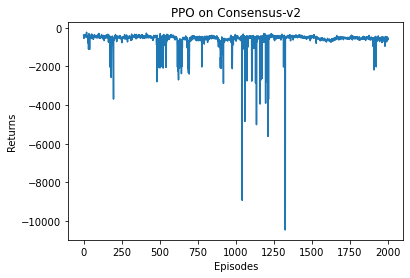

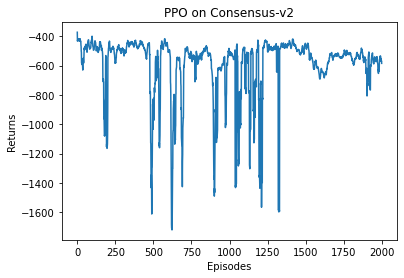

In [5]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1) + 1e-10
    


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,lmbda, epochs, eps, gamma, device):
        # 创建并初始化策略网络（Actor）和价值网络（Critic）
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)

        # 定义策略网络和价值网络的优化器，使用Adam优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda   # Generalized Advantage Estimation (GAE)的参数
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device
        

    def take_action(self, state):
        # 将输入状态转换为PyTorch张量，并移动到指定的设备（CPU或GPU）
        state = torch.tensor([state], dtype=torch.float).to(self.device)

        # 通过策略网络（Actor）获取在当前状态下采取每个动作的概率分布
        probs = self.actor(state)

        # 使用Categorical分布对象根据概率分布进行采样，得到选定的动作
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()

        return action.item()

    def update(self, transition_dict):
        # 从传入的transition_dict中获取训练所需的数据
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

         # 计算 TD 目标（Temporal Difference Target）
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)

        # 计算 TD 误差（Temporal Difference Delta）
        td_delta = td_target - self.critic(states)

        # 计算 Advantage（优势函数）
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)

        # 计算旧的动作概率的对数值
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()

        for _ in range(self.epochs):
            # 计算新的动作概率的对数值
            log_probs = torch.log(self.actor(states).gather(1, actions))

            # 计算 PPO 损失函数的比率（Clipped Surrogate Objective）
            ratio = torch.exp(log_probs - old_log_probs)

            # 计算两个截断项（clipping terms）
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断

            # 计算 PPO 损失函数
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数

            # 计算 Critic 损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

            # 梯度清零
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()

            # 反向传播和梯度更新
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 2000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Consensus-v2'  #Consensus-v0
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)
episodes_list = list(range(len(return_list)))

plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()